Step 1: Load and inspect data

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Load dataset
df = pd.read_csv("data/diamonds.csv")  # your CSV path
df.head()

# Basic info
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Check unique values for categorical columns
print("Cut:", df['cut'].unique())
print("Color:", df['color'].unique())
print("Clarity:", df['clarity'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None
              carat         depth         table         price             x  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184   3932.799722      5.731157   
std        0.474011      1.432621      2.234491   3989.439738      1.121761   
min        0.200000     43.000000     43.000000    3

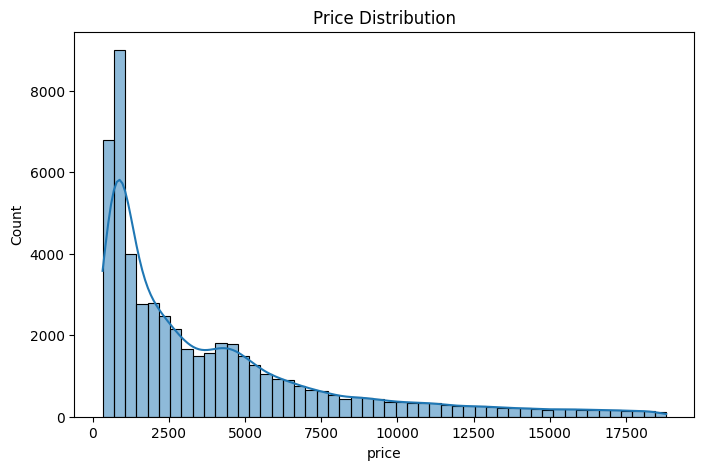

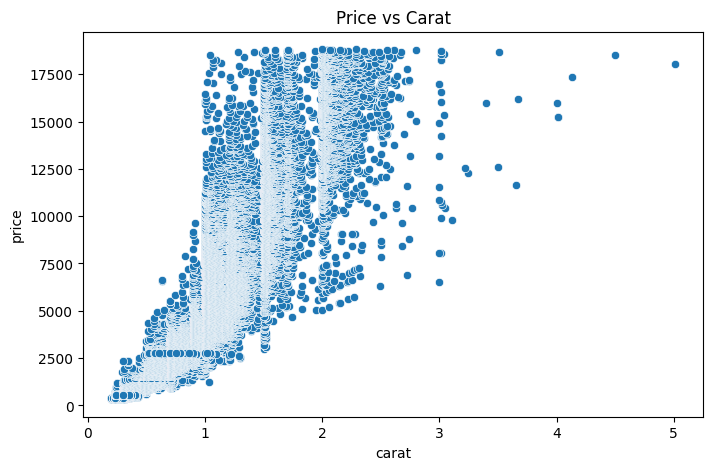

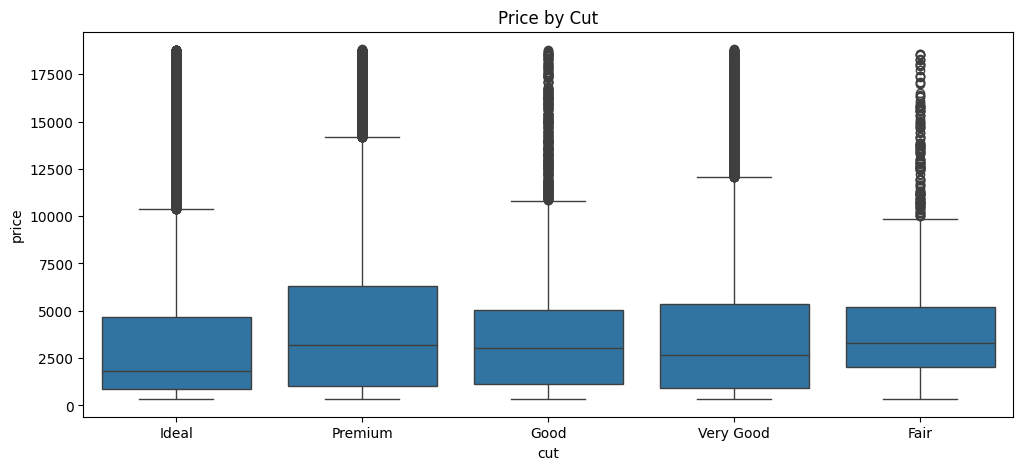

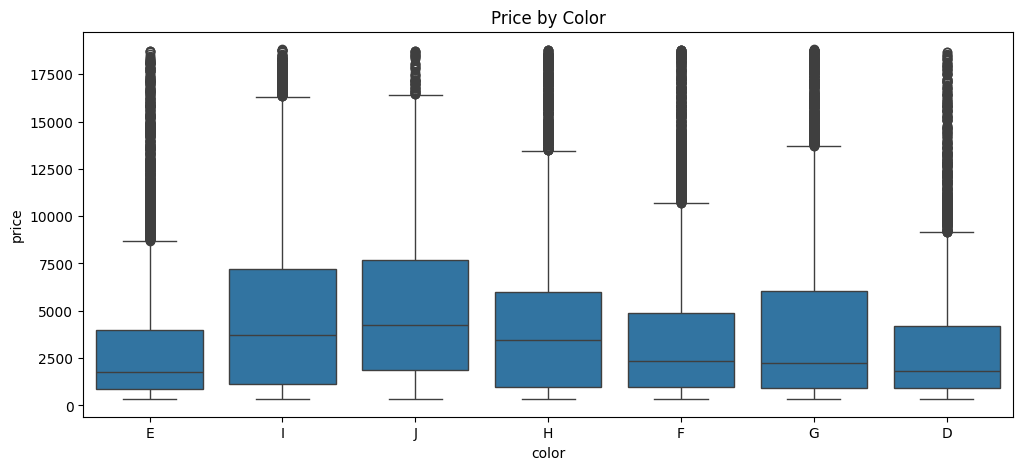

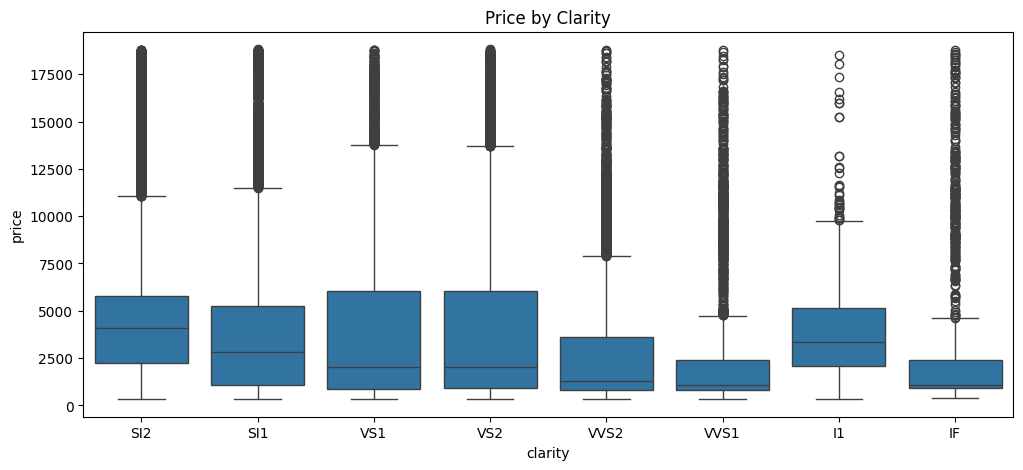

In [8]:
# Price distribution
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

# Price vs Carat
plt.figure(figsize=(8,5))
sns.scatterplot(x='carat', y='price', data=df)
plt.title("Price vs Carat")
plt.show()

# Boxplots for categorical features
plt.figure(figsize=(12,5))
sns.boxplot(x='cut', y='price', data=df)
plt.title("Price by Cut")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='color', y='price', data=df)
plt.title("Price by Color")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='clarity', y='price', data=df)
plt.title("Price by Clarity")
plt.show()


Data Preprocessing

In [9]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Encode categorical columns
encoder = OrdinalEncoder()
df[['cut_ord', 'color_ord', 'clarity_ord']] = encoder.fit_transform(df[['cut', 'color', 'clarity']])

# Save encoder for Streamlit
import pickle
with open(os.path.join(ARTIFACTS_DIR, "encoder.pkl"), "wb") as f:
    pickle.dump(encoder, f)

# Log-transform skewed numeric features
for col in ['carat', 'depth', 'table', 'x', 'y', 'z']:
    df[f'{col}_log'] = np.log1p(df[col])

# Scale numeric features
scaler = StandardScaler()
num_cols = [f'{col}_log' for col in ['carat', 'depth', 'table', 'x', 'y', 'z']]
df[num_cols] = scaler.fit_transform(df[num_cols])

# Save scaler
with open(os.path.join(ARTIFACTS_DIR, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

# Features for ML & ANN
model_features = num_cols + ['cut_ord', 'color_ord', 'clarity_ord']
with open(os.path.join(ARTIFACTS_DIR, "model_features.pkl"), "wb") as f:
    pickle.dump(model_features, f)


Step 4: ML Model Training & Evaluation

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pickle

# Train-test split
X = df[model_features]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Evaluation function
def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2_score(y_true, y_pred)
    }

# Evaluate
lr_metrics = eval_metrics(y_test, lr_model.predict(X_test))
rf_metrics = eval_metrics(y_test, rf_model.predict(X_test))
print("Linear Regression Metrics:", lr_metrics)
print("Random Forest Metrics:", rf_metrics)

# Save best performing model (choose by R2)
best_model = rf_model if rf_metrics['R2'] > lr_metrics['R2'] else lr_model
with open(os.path.join(ARTIFACTS_DIR, "best_model.pkl"), "wb") as f:
    pickle.dump(best_model, f)
    

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

print("Random Forest Model Trained!")


print("✔ Best model saved successfully!")


Linear Regression Metrics: {'MAE': 960.516727089074, 'MSE': 2078273.9827895665, 'RMSE': np.float64(1441.621997192595), 'R2': 0.8692648093732669}
Random Forest Metrics: {'MAE': 268.1924747691438, 'MSE': 295256.0571485219, 'RMSE': np.float64(543.3746931432507), 'R2': 0.9814267236973259}
Random Forest Model Trained!
✔ Best model saved successfully!


In [22]:
import os
import pickle

ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

with open(os.path.join(ARTIFACTS_DIR, "rf_model.pkl"), "wb") as f:
    pickle.dump(rf_model, f)

print("✔ Random Forest model saved as rf_model.pkl")


✔ Random Forest model saved as rf_model.pkl


Step 5: ANN Model Training (PyTorch)

In [20]:
import torch
import torch.nn as nn

# Define ANN model class
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
        from sklearn.preprocessing import StandardScaler
import torch

# X_train_scaled, X_test_scaled should be your current 9-feature dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
input_dim = X_train_scaled.shape[1]  # 9 features
ann_model = ANNModel(input_dim=input_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ann_model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = ann_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
import os

ARTIFACTS_DIR = "artifacts"
if not os.path.exists(ARTIFACTS_DIR):
    os.makedirs(ARTIFACTS_DIR)

# Save trained ANN
torch.save(ann_model.state_dict(), os.path.join(ARTIFACTS_DIR, "ann_model.pth"))

# Save the scaler
import pickle
with open(os.path.join(ARTIFACTS_DIR, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print("✔ ANN model and scaler saved successfully!")



Epoch [10/100], Loss: 31435472.0000
Epoch [20/100], Loss: 31431438.0000
Epoch [30/100], Loss: 31425976.0000
Epoch [40/100], Loss: 31418280.0000
Epoch [50/100], Loss: 31407360.0000
Epoch [60/100], Loss: 31391968.0000
Epoch [70/100], Loss: 31370580.0000
Epoch [80/100], Loss: 31341538.0000
Epoch [90/100], Loss: 31302992.0000
Epoch [100/100], Loss: 31253006.0000
✔ ANN model and scaler saved successfully!


Step 6: Clustering (Market Segmentation) + PCA

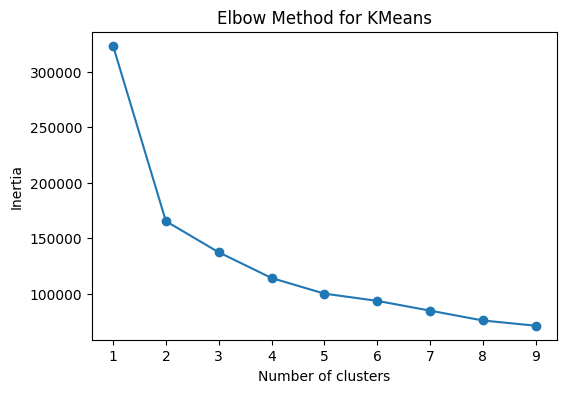

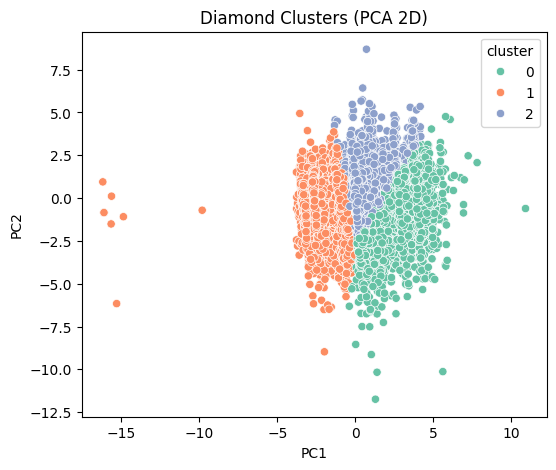

✔ Clustering + PCA done and saved successfully!


In [13]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Use only numeric features for clustering
cluster_features = ['carat_log', 'depth_log', 'table_log', 'x_log', 'y_log', 'z_log']

# Standardize numeric features
scaler_clust = StandardScaler()
X_cluster_scaled = scaler_clust.fit_transform(df[cluster_features])

# Save scaler for Streamlit
with open(os.path.join(ARTIFACTS_DIR, "scaler_clust.pkl"), "wb") as f:
    pickle.dump(scaler_clust, f)

# Determine optimal number of clusters using Elbow Method
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_cluster_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(1,10), inertia, marker='o')
plt.title("Elbow Method for KMeans")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

# Fit K-Means with optimal clusters (example: 3)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Save KMeans model
with open(os.path.join(ARTIFACTS_DIR, "kmeans_model.pkl"), "wb") as f:
    pickle.dump(kmeans, f)

# PCA for visualization (2 components)
pca = PCA(n_components=2, random_state=42)
df[['PC1','PC2']] = pca.fit_transform(X_cluster_scaled)

# Save PCA model
with open(os.path.join(ARTIFACTS_DIR, "pca_model.pkl"), "wb") as f:
    pickle.dump(pca, f)

# Optional: visualize clusters
plt.figure(figsize=(6,5))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df, palette='Set2')
plt.title("Diamond Clusters (PCA 2D)")
plt.show()

# Analyze clusters to name them
cluster_summary = df.groupby('cluster').agg({
    'price': 'mean',
    'carat_log': 'mean'
}).reset_index()

cluster_names = {}
for idx, row in cluster_summary.iterrows():
    if row['carat_log'] > df['carat_log'].median() and row['price'] > df['price'].median():
        cluster_names[row['cluster']] = "Premium Heavy Diamonds"
    elif row['carat_log'] < df['carat_log'].median() and row['price'] < df['price'].median():
        cluster_names[row['cluster']] = "Affordable Small Diamonds"
    else:
        cluster_names[row['cluster']] = "Mid-range Balanced Diamonds"

df['cluster_name'] = df['cluster'].map(cluster_names)

# Save cluster names mapping
with open(os.path.join(ARTIFACTS_DIR, "cluster_names.pkl"), "wb") as f:
    pickle.dump(cluster_names, f)

print("✔ Clustering + PCA done and saved successfully!")


In [23]:
# Suppose your KMeans clustering is done and you have cluster labels
# and you want to assign names based on average price/carat

cluster_names = {
    0: "Affordable Small Diamonds",
    1: "Mid-range Balanced Diamonds",
    2: "Premium Heavy Diamonds"
}

# Save this mapping
import pickle
with open("artifacts/cluster_name_mapping.pkl", "wb") as f:
    pickle.dump(cluster_names, f)

print("✔ cluster_name_mapping.pkl saved")


✔ cluster_name_mapping.pkl saved


In [24]:
kmeans_features = ['carat_log', 'depth_log', 'table_log', 'x_log', 'y_log', 'z_log']

with open("artifacts/kmeans_features.pkl", "wb") as f:
    pickle.dump(kmeans_features, f)


In [15]:
from sklearn.preprocessing import OrdinalEncoder
import pickle
import os

ARTIFACTS_DIR = "artifacts"
if not os.path.exists(ARTIFACTS_DIR):
    os.makedirs(ARTIFACTS_DIR)

# Categorical columns
cat_cols = ['cut', 'color', 'clarity']

# Create encoder dict
encoder_dict = {}
for col in cat_cols:
    encoder = OrdinalEncoder()
    df[[col + "_ord"]] = encoder.fit_transform(df[[col]])
    encoder_dict[col] = encoder

# Save encoder_dict
with open(os.path.join(ARTIFACTS_DIR, "encoder_dict.pkl"), "wb") as f:
    pickle.dump(encoder_dict, f)

print("✔ Encoder dict saved successfully!")


✔ Encoder dict saved successfully!
